<IPython.core.display.Javascript object>


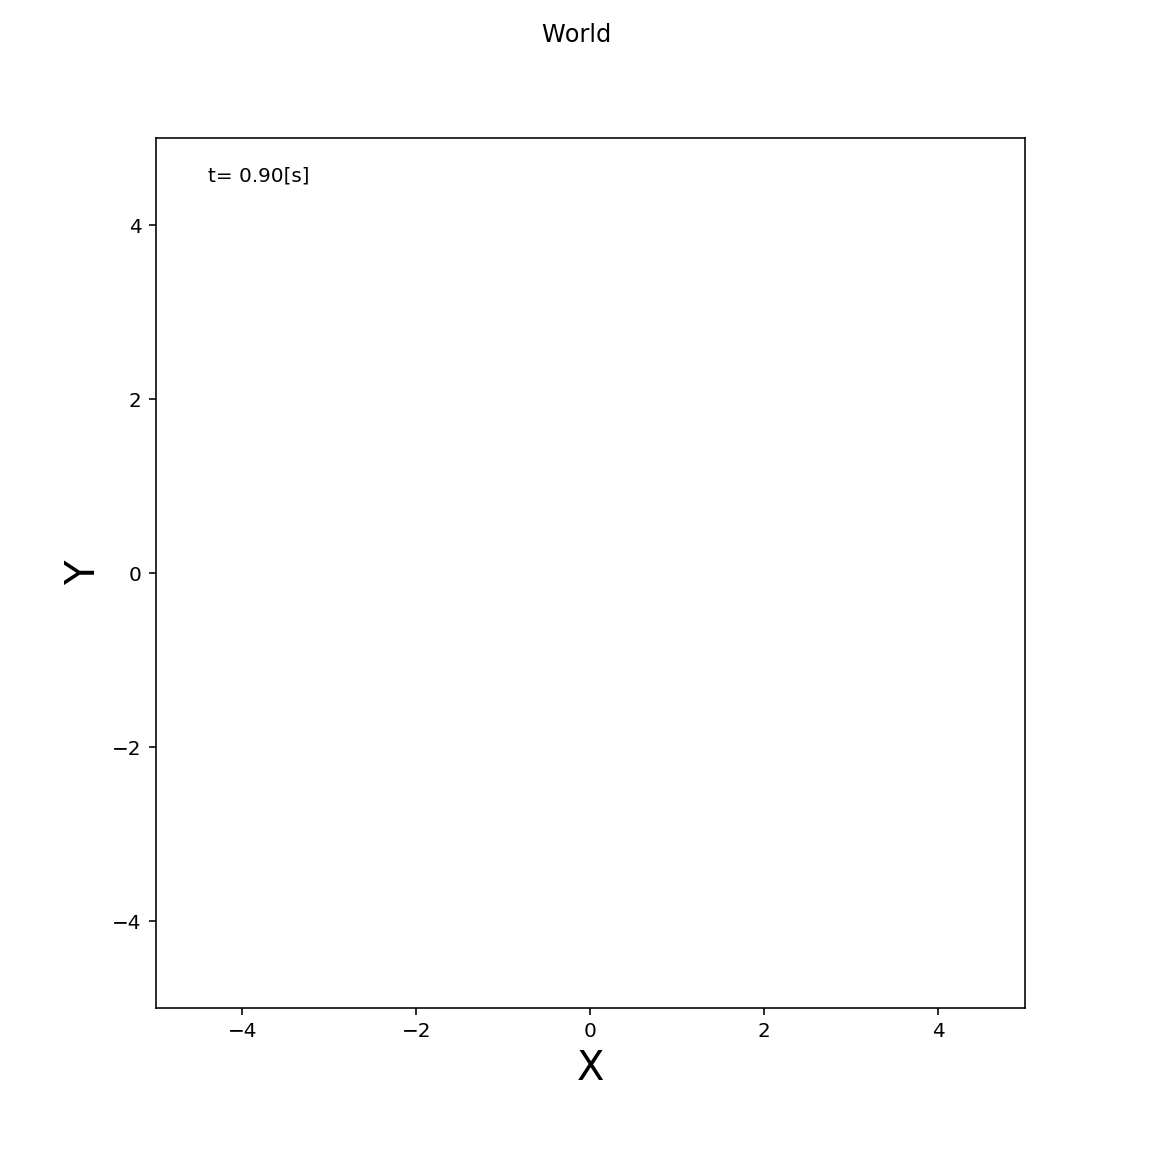

In [24]:
# Worldの描画
from sys import path
path.append('../src')
import importlib

import worlds
import robots
import agents
import maps
import landmarks
import sensors
    
def reload():
    importlib.reload(worlds)
    importlib.reload(robots)
    importlib.reload(agents)
    importlib.reload(maps)
    importlib.reload(landmarks)
    importlib.reload(sensors)
    
reload()

world = worlds.World(1.0, 0.1, debuggable=False)
world.draw()

<IPython.core.display.Javascript object>


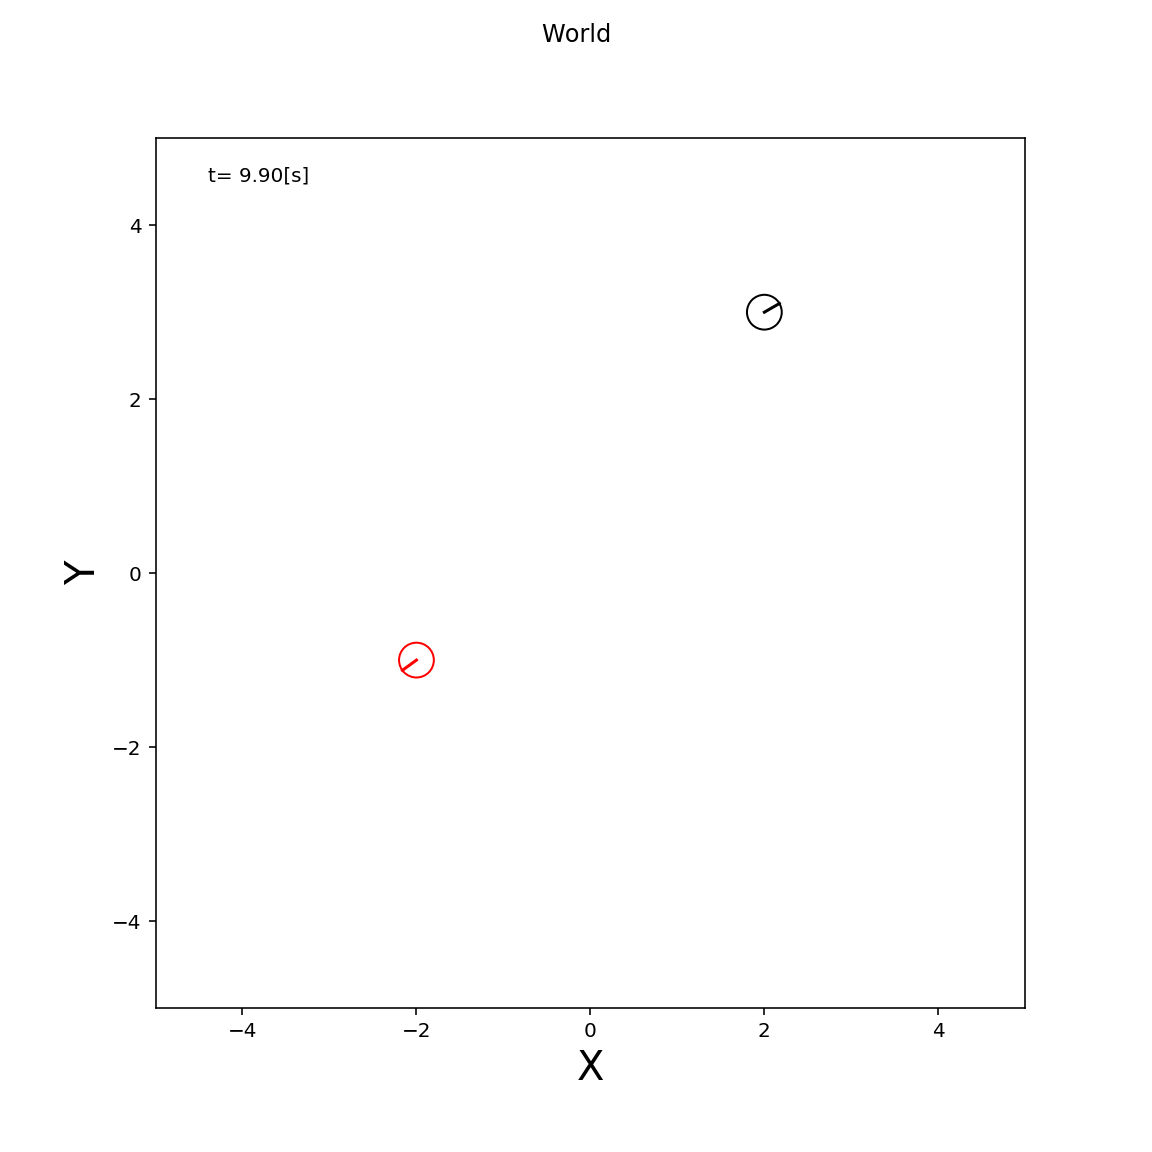

In [35]:
# ロボットを描画
import numpy as np
from math import pi
reload()

world = worlds.World(10.0, 0.1, debuggable=False)

robot1 = robots.IdealRobot(np.array([2., 3., pi / 6.]).T, color='black')
robot2 = robots.IdealRobot(np.array([-2., -1., pi / 5. * 6.]).T, color='red')

world.append(robot1)
world.append(robot2)

world.draw()

制御司令を与えてみる

- 前方方向の速度$v$[m/s]
- ロボット中心の角速度$\omega$[rad/s]

それらを含むベクトルを制御指令とする

$$
{\bf u} = \left(
    \begin{array}{c}
            v \\
            \omega
    \end{array}
\right) \\
$$

2D座標では下記のように速度を表現できる

$$
{\bf \dot{x}} = \left(
    \begin{array}{c}
            \dot{x} \\
            \dot{y} \\
            \dot{\theta}
    \end{array}
\right) = \left(
    \begin{array}{c}
            v\cos{\theta} \\
            v\sin{\theta} \\
            \omega
    \end{array}
\right)
$$

時間変化でこれがどう変わっていくかかんがえる

${\bf x}_{t-1}$と${\bf x}_{t}$の関係が知りたい

向き$\theta_{t}$については、$\omega$を$t$について積分する

$$
\theta_{t} = \theta_{t-1} + \int_{0}^{\Delta t}\omega_{t}dt = \theta_{t-1} + \omega_{t}\Delta t
$$

位置についてはすこしややこしい(省略)

最終的に、下記のような状態遷移関数を定義することがスタート地点

${\bf x}_{t-1}$から${\bf x}_{t}$を求めるための関数

$$
{\bf x}_{t} = {\bf f}({\bf x}_{t-1}, {\bf u})
$$

In [36]:
# 状態遷移関数をIdealRobotに実装したので試しにcall
reload()

# 0.1[m/s], 1.0[s]直進
robots.IdealRobot.state_transition(
    0.1, 0.0, 1.0, np.array([0, 0, 0]).T)

# 0.1[m/s], 10[deg/s] 9.0[s]移動
robots.IdealRobot.state_transition(
    0.1, 10. / 180. * pi, 9.0, np.array([0, 0, 0]).T)

# 0.1[m/s], 10[deg/s] 18.0[s]移動
robots.IdealRobot.state_transition(
    0.1, 10. / 180. * pi, 18.0, np.array([0, 0, 0]).T)

array([7.01670930e-17, 1.14591559e+00, 3.14159265e+00])

<IPython.core.display.Javascript object>


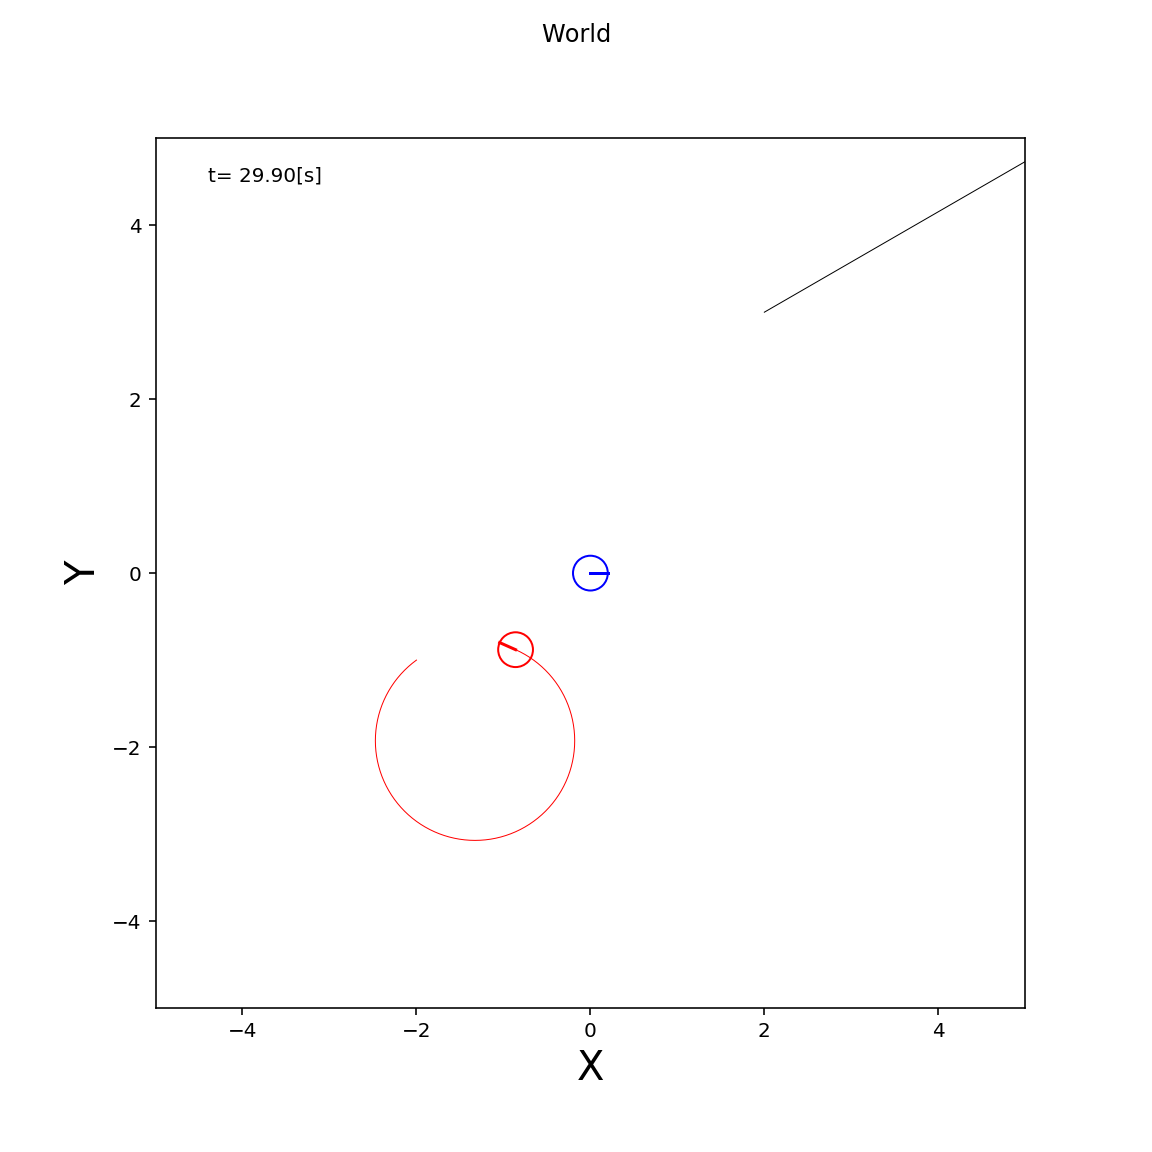

In [37]:
# 指令を与えるためのエージェントを実装したので使ってみる
reload()

world = worlds.World(30., 0.1, debuggable=False)

straight = agents.Agent(0.2, 0.)
circling = agents.Agent(0.2, 10. / 180. * pi)

robot1 = robots.IdealRobot(
    np.array([2., 3., pi / 6.]).T, straight)
robot2 = robots.IdealRobot(
    np.array([-2., -1., pi / 5. * 6.]).T, circling, 'red')
robot3 = robots.IdealRobot(
    np.array([0., 0., 0.]).T, color='blue')

world.append(robot1)
world.append(robot2)
world.append(robot3)

world.draw()

ランドマークを追加する

マップ上に点として存在するものを考える

（姿勢は観測されない）

全ランドマークの位置を記録した地図を

$$
{\bf m} =  \{ m_{i} \mid j = 0, 1, 2, \cdots , N_{m} - 1 \}
$$

<IPython.core.display.Javascript object>


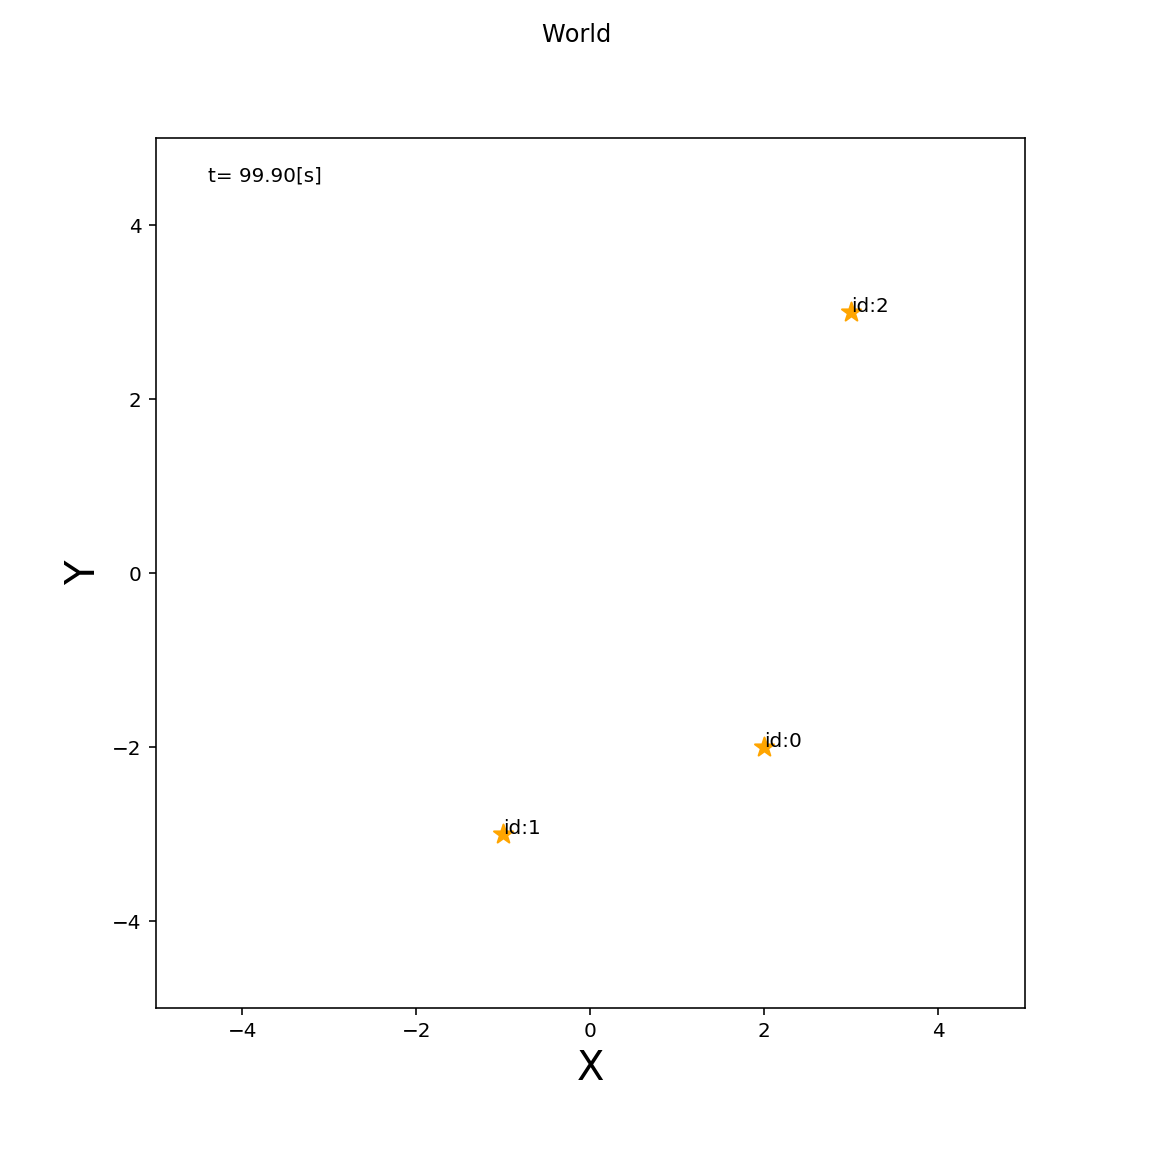

In [28]:
# 表示させる
reload()

m = maps.Map()
m.append_landmark(landmarks.Landmark(2, -2))
m.append_landmark(landmarks.Landmark(-1, -3))
m.append_landmark(landmarks.Landmark(3, 3))

world = worlds.World(10, 0.1, debuggable=True)
world.append(m)
world.draw()

ランドマークをロボットで観測することを考える

→ 観測方程式を立てる

カメラでロボット相対のランドマークへの距離と角度が得られるとする

$$
{\bf z}_{j, t} = \left( l_{j, t}, \phi_{j, t}\right)^{\top}
$$

$l_{j}$は距離(m), $\phi_{j}$は角度(rad), $t$は時刻$t$（${\bf u}_{t}$で移動した直後)

$$
l_{j} = |{\bf m}_{j} - {\bf x} | = \sqrt{\left(m_{j, x} - x \right)^{2} + \left( m_{j, y} - y \right)^{2}}
$$

角度$\phi_{j}$はロボットのマップ相対の姿勢$\theta$をマップ相対のランドマークへのベクトルの角度から引いたものになるので

$$
\phi_{j} = \arctan(m_{j, y} - y, m_{j, x} - x) - \theta \\
- \pi \le \phi_{j} < \pi
$$

観測方程式としての体裁を整えると

$$
\left(
    \begin{array}{cc}
        l_{j} \\
        \phi_{j}
    \end{array} 
\right) = \left(
    \begin{array}{cc}
        \sqrt{\left(m_{j, x} - x \right)^{2} + \left( m_{j, y} - y \right)^{2}} \\
        \arctan(m_{j, y} - y, m_{j, x} - x) - \theta
    \end{array} 
\right) \\
\\
{\bf z}_{j} = {\bf h}({\bf x}, {\bf m}_{j})
$$

となる

In [40]:
# カメラクラスを実装したので動作確認
reload()

# カメラにマップを登録（倒錯してる？）
cam = sensors.IdealCamera(m)

p = cam.data(robot2.pose)
print(p)

2.2064028056776968
1.169301513076494
6.060408144475324
[(array([2.20640281, 4.97046572]), 0), (array([1.16930151, 8.86515825]), 1), (array([6.06040814, 5.91859927]), 2)]
